In [28]:
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.transforms.transforms as T

USE_GPU = True

TRAIN_SET_NUM = 49000
BATCH_SIZE = 64
EPOCH_NUM = 20

# 数据预处理
transform_normal = T.Compose([
    T.ToTensor(), 
    T.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
])

# 数据增强



# 加载训练集
train_dataset = torchvision.datasets.CIFAR10(root='./', train=True, transform=transform_normal, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(TRAIN_SET_NUM)))

# 加载验证集
val_dataset = torchvision.datasets.CIFAR10(root='./', train=True, transform=transform_normal, download=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(TRAIN_SET_NUM, 50000)))

# 加载测试集
test_dataset = torchvision.datasets.CIFAR10(root='./', train=False, transform=transform_normal, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


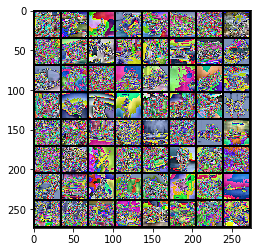

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    nping = img.numpy()
    nping = nping.transpose((1, 2, 0))
    plt.imshow(nping)

dataiter = iter(train_dataloader)
data = dataiter.next()
images, labels = data
imshow(torchvision.utils.make_grid(images))

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
    
        self.fc1 = nn.Linear(3 * 32 * 32, 4096)
        self.fc2 = nn.Linear(4096, 10)

    def forward(self, x):
        # flatten
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 16, 3)
        self.fc = nn.Linear(16*28*28, 10)

    def forward(self, x):
        # flatten
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.fc1 = nn.Linear(32*4*4, 32*4*4)
        self.fc2 = nn.Linear(32*4*4, 32*2*2)
        self.fc3 = nn.Linear(32*2*2, 10)

    def forward(self, x):
        x = self.conv1(x)               # [64, 16, 32, 32]   
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)       # [64, 16, 16, 16]

        x = self.conv2(x)               # [64, 32, 16, 16]   
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)       # [64, 32, 8, 8]

        x = self.conv3(x)               # [64, 32, 8, 8]
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)       # [64, 32, 4, 4]

        x = x.view(x.shape[0], -1)      # [64, 512]

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

net3 = Net3()
print(net3)

Net3(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [13]:
import copy

train_loss_hist = []
test_loss_hist = []

# 验证模型在验证集或者测试集上的准确率
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()   # set model to evaluation mode
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _,preds = scores.max(1)
            num_correct += (preds==y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 *acc ))
        return acc

def train_model(model, optimizer, epochs=1, scheduler=None):
    '''
    Parameters:
    - model: A Pytorch Module giving the model to train.
    - optimizer: An optimizer object we will use to train the model
    - epochs: A Python integer giving the number of epochs to train
    Returns: best model
    '''
    best_model_wts = None
    best_acc = 0.0
    model = model.to(device=device) # move the model parameters to CPU/GPU
    for e in range(epochs):
        if scheduler:
            scheduler.step()
        for t,(x,y) in enumerate(train_dataloader):
            model.train()   # set model to training mode
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch %d, loss=%.4f' % (e, loss.item()))
        acc = check_accuracy(val_dataloader, model)
        if acc > best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            best_acc = acc
    print('best_acc:',best_acc)
    model.load_state_dict(best_model_wts)
    return model

In [30]:
optimizer = optim.SGD(net3.parameters(), lr=1e-2, momentum=0.9)

best_model = train_model(net3, optimizer, epochs=EPOCH_NUM)

Epoch 0, loss=0.5200
Checking accuracy on validation set
Got 707 / 1000 correct (70.70)
Epoch 1, loss=0.8529
Checking accuracy on validation set
Got 694 / 1000 correct (69.40)
Epoch 2, loss=0.6508
Checking accuracy on validation set
Got 711 / 1000 correct (71.10)
Epoch 3, loss=0.7817
Checking accuracy on validation set
Got 703 / 1000 correct (70.30)
Epoch 4, loss=0.6242
Checking accuracy on validation set
Got 710 / 1000 correct (71.00)
Epoch 5, loss=0.8773
Checking accuracy on validation set
Got 720 / 1000 correct (72.00)
Epoch 6, loss=0.8955
Checking accuracy on validation set
Got 720 / 1000 correct (72.00)
Epoch 7, loss=0.7080
Checking accuracy on validation set
Got 709 / 1000 correct (70.90)
Epoch 8, loss=0.5892
Checking accuracy on validation set
Got 716 / 1000 correct (71.60)
Epoch 9, loss=0.5129
Checking accuracy on validation set
Got 715 / 1000 correct (71.50)
Epoch 10, loss=0.6935
Checking accuracy on validation set
Got 709 / 1000 correct (70.90)
Epoch 11, loss=0.5635
Checking 

In [31]:
check_accuracy(test_dataloader, best_model)

Checking accuracy on test set
Got 7168 / 10000 correct (71.68)


0.7168

In [ ]:
# 2 fc 46.53%
# 2 cnn 59.76%
# 3 cnn 3 fc 72.12%
#